Optimal alpha: 0.11369924366926064
Optimal x* for this alpha: [[-0.50277995 -0.08703967]
 [-0.38499793 -0.06707113]
 [-0.46038652  0.18618346]
 [-0.57682596  0.01189069]]


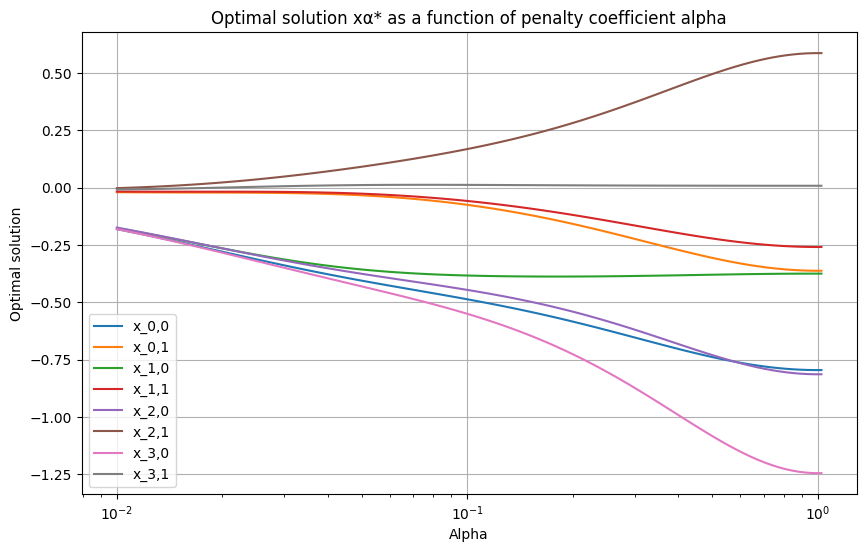

In [29]:
import numpy as np
from scipy.linalg import inv
import matplotlib.pyplot as plt

# Define the rotation matrix L(theta)
def L(theta):
    L_base = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    return L_base

# Define the diagonal matrix D(gamma)
def D(gamma):
    D_base = np.diag([gamma, 1/gamma])
    return D_base

# Define the total cost function with penalty
def cost_function(x, alpha):
    x = np.array(x).reshape(n, p)  # Reshape x to be n x p
    # Reconstruct the vector x_i and compute F(x)
    F_x = 0
    for i in range(n):
        x_i = x[i].reshape(-1, 1)  # Convert x_i to column vector (2x1)
        F_x += x_i.T @ A_matrices[i] @ x_i + b_vectors[i].T @ x_i
    # Compute the penalty term
    penalty_term = 0.5 * np.linalg.norm(V @ x.flatten()) ** 2
    cost = alpha * F_x + penalty_term
    return cost.flatten()[0]

# Define the gradient of the cost function
def gradient(x, alpha):
    x = x.reshape(n, p)
    grad = np.zeros_like(x)

    for i in range(n):
        x_i = x[i].reshape(-1, 1)
        grad_i = 2 * (A_matrices[i] @ x_i + b_vectors[i])
        grad[i] = grad_i.flatten()
    
    # Add the penalty gradient
    penalty_grad = V.T @ (V @ x.flatten())
    grad += alpha * penalty_grad.reshape(n, p)
    
    return grad.flatten()

# Adjacency list for the graph (undirected)
adj_list = {
    0: [1, 2],  # Neighbors of node 0
    1: [0, 3],  # Neighbors of node 1
    2: [0, 3],  # Neighbors of node 2
    3: [1, 2]   # Neighbors of node 3
}

# Number of nodes
n = 4
# Dimension of x_i
p = 2  

# Initialize the weight matrix W
W = np.zeros((n, n))
for i in range(n):
    neighbors = adj_list[i]
    weight = 1 / len(neighbors)
    for j in neighbors:
        W[i, j] = weight

# Define edges for incidence matrix
edges = [(0, 1), (1, 3), (3, 2), (2, 0)]
m = len(edges)

# Compute the incidence matrix B
B = np.zeros((m, n))
for idx, (i, j) in enumerate(edges):
    weight = np.sqrt(W[i, j])
    B[idx, i] = weight
    B[idx, j] = -weight

# Define V as B ⊗ I, where I is a 2x2 identity matrix
I_2 = np.eye(p)  # 2x2 identity matrix
V = np.kron(B, I_2)  # Kronecker product of B and I_2

# Define the parameters for each node
i_values = np.arange(1, 5)  # This creates an array [1, 2, 3, 4]
# Compute θ_i = i * π / 4
theta_values = i_values * (np.pi / 4)
# Compute γ_i = 1/2^i
gamma_values = 1/(2**i_values)

# Calculate A_i and b_i for each node
A_matrices = [L(theta_values[i]).dot(D(gamma_values[i])).dot(inv(L(theta_values[i]))) for i in range(4)]
b_vectors = [L(np.pi/8)**i @ np.array([[1], [0]]) for i in i_values]  # Adjusted size to 2x1

# Define the penalty coefficient
alpha_values = np.logspace(-2, 0.01, num=100)

# Distributed gradient descent parameters
max_iterations = 1500
tolerance = 1e-6

# Store optimal solutions and costs
optimal_solutions = []
costs = []
fixed_step_size = 0.01

# Optimize the function for different alpha values using distributed gradient descent
for alpha in alpha_values:
    # Initialize solutions for each node
    x_nodes = np.zeros((n, p))

    for k in range(max_iterations):
        # Exchange iterates with neighbors
        x_neighbors = np.copy(x_nodes)
        
        # Compute gradients for each node
        g_nodes = gradient(x_nodes.flatten(), alpha).reshape(n, p)
        
        # Compute the gradient for each node
        for i in range(n):
            # Get the indices of the neighbors for node i
            neighbors = adj_list[i]
            
            # Calculate the weighted sum of the neighbors' values
            neighbor_sum = np.sum(W[i, neighbors] * x_neighbors[neighbors], axis=0)
            
            # Gradient computation
            g_i_k = alpha * g_nodes[i] + x_nodes[i] - neighbor_sum  # Note: x_nodes[i] has to be a (2,) shape vector
            
            # Update local iterate
            x_nodes[i] -= g_i_k * fixed_step_size  # Diminishing step size
            
        # Check for convergence
        if np.linalg.norm(g_nodes) < tolerance:
            break

    # Store results for this alpha
    optimal_solutions.append(x_nodes.copy())
    costs.append(cost_function(x_nodes.flatten(), alpha))

# Convert to a numpy array for easier plotting
optimal_solutions = np.array(optimal_solutions)
costs = np.array(np.abs(costs))

# Find the index of the minimum cost
min_cost_index = np.argmin(costs)
optimal_alpha = alpha_values[min_cost_index]
optimal_x_star = optimal_solutions[min_cost_index]

# Print results
print(f"Optimal alpha: {optimal_alpha}")
print(f"Optimal x* for this alpha: {optimal_x_star}")

# Plot the results
plt.figure(figsize=(10, 6))
for i in range(n):
    for j in range(p):
        plt.plot(alpha_values, optimal_solutions[:, i, j], label=f'x_{i},{j}')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Optimal solution')
plt.title('Optimal solution xα* as a function of penalty coefficient alpha')
plt.legend()
plt.grid(True)
plt.show()


Final optimal x* for alpha = 0.01:
[[-0.18083348 -0.019683  ]
 [-0.17567673 -0.01689823]
 [-0.17408311 -0.0019153 ]
 [-0.18071619 -0.00777543]]


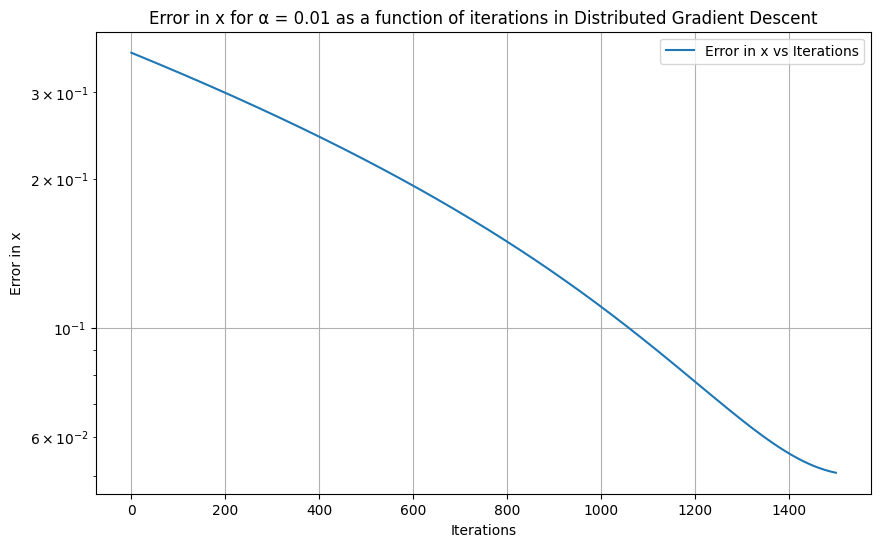

In [34]:
# Define the fixed penalty coefficient
#alpha = 0.11369924366926064
alpha = 0.01

# Store optimal solutions and costs
optimal_solutions = []
costs = []
fixed_step_size = 0.01

# Store errors for plotting
errors = []

# Define optimal_x_star Optimal solution x*: [-0.17997322  0.0125382 ]
optimal_x_star = np.array([[-0.17997322, 0.0125382],
                            [-0.17997322, 0.0125382],
                            [-0.17997322,  0.0125382],
                            [-0.17997322,  0.0125382]])

# Optimize the function for the fixed alpha value using distributed gradient descent
# Initialize solutions for each node
x_nodes = np.zeros((n, p))

for k in range(max_iterations):
    # Exchange iterates with neighbors
    x_neighbors = np.copy(x_nodes)
    
    # Compute gradients for each node
    g_nodes = gradient(x_nodes.flatten(), alpha).reshape(n, p)
    
    # Compute the gradient for each node
    for i in range(n):
        # Get the indices of the neighbors for node i
        neighbors = adj_list[i]
        
        # Calculate the weighted sum of the neighbors' values
        neighbor_sum = np.sum(W[i, neighbors] * x_neighbors[neighbors], axis=0)
        
        # Gradient computation
        g_i_k = alpha * g_nodes[i] + x_nodes[i] - neighbor_sum
        
        # Update local iterate
        x_nodes[i] -= g_i_k * fixed_step_size
        
    # Calculate error for the current iteration
    error_k = np.linalg.norm(x_nodes - optimal_x_star)  # Calculate error from optimal_x_star
    errors.append(error_k)  # Store current error
    
    # Check for convergence
    if np.linalg.norm(g_nodes) < tolerance:
        break

# Store results for this alpha
optimal_solutions.append(x_nodes.copy())
costs.append(cost_function(x_nodes.flatten(), alpha))

# Convert to a numpy array for easier plotting
optimal_solutions = np.array(optimal_solutions)
costs = np.array(np.abs(costs))
errors = np.array(errors)

# Print results
print(f"Final optimal x* for alpha = {alpha}:")
print(optimal_solutions[-1])

# Plot the error as a function of iterations
plt.figure(figsize=(10, 6))
plt.plot(errors, label='Error in x vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Error in x')
plt.title('Error in x for α = 0.01 as a function of iterations in Distributed Gradient Descent')
plt.yscale('log')  # Log scale if errors vary greatly
plt.grid(True)
plt.legend()
plt.show()


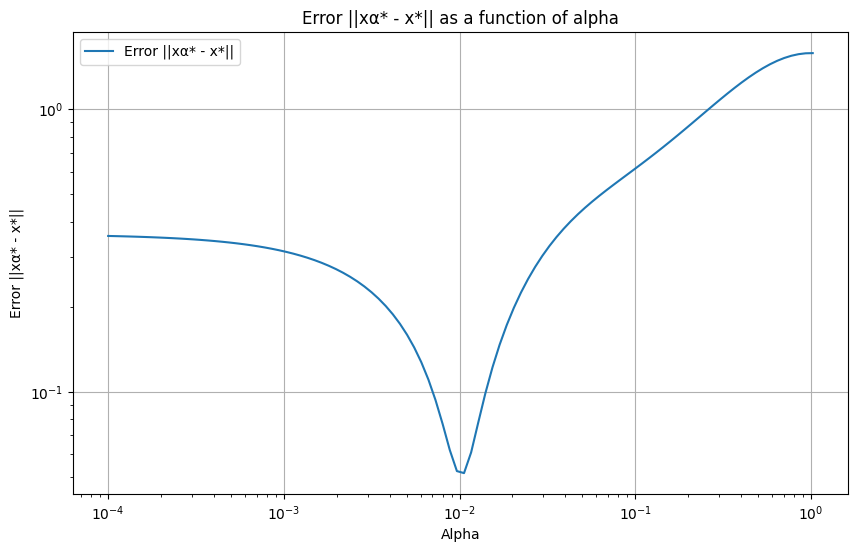

In [35]:

optimal_x_star = np.array([[-0.17997322, 0.0125382],
                           [-0.17997322, 0.0125382],
                           [-0.17997322, 0.0125382],
                           [-0.17997322, 0.0125382]])

errors_alpha = []
alpha_values = np.logspace(-4, 0.01, num=100)
for alpha in alpha_values:
    x_nodes = np.zeros((n, p))

    for k in range(max_iterations):
        x_neighbors = np.copy(x_nodes)
        g_nodes = gradient(x_nodes.flatten(), alpha).reshape(n, p)

        for i in range(n):
            neighbors = adj_list[i]
            neighbor_sum = np.sum(W[i, neighbors] * x_neighbors[neighbors], axis=0)
            g_i_k = alpha * g_nodes[i] + x_nodes[i] - neighbor_sum
            x_nodes[i] -= g_i_k * fixed_step_size

        if np.linalg.norm(g_nodes) < tolerance:
            break
    
    error_alpha = np.linalg.norm(x_nodes - optimal_x_star)
    errors_alpha.append(error_alpha)

# Σχεδίαση του σφάλματος ως συνάρτηση του alpha
plt.figure(figsize=(10, 6))
plt.plot(alpha_values, errors_alpha, label='Error ||xα* - x*||')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Alpha')
plt.ylabel('Error ||xα* - x*||')
plt.title('Error ||xα* - x*|| as a function of alpha')
plt.grid(True)
plt.legend()
plt.show()